In [1]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# Depending on your runtime environment you may need the following lines\

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# The tensorflow.keras.preprocessing library contains classes that
# simplify basic data collection and processing.
# https://keras.io/api/preprocessing/image/#imagedatagenerator-class
datagen = image.ImageDataGenerator(
    validation_split=0.2,
    dtype="float32"
)

dir_path = "../../leabra"
img_size = (200, 200)

# imort training data
train = datagen.flow_from_directory(
    dir_path,
    target_size=img_size,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=2000,
    shuffle=True,
    seed=50,
    subset="training"
)

# import testing data
test = datagen.flow_from_directory(
    dir_path,
    target_size=img_size,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=2000,
    shuffle=True,
    seed=50,
    subset="validation"
)

# Converts tf.data.Dataset object to a numpy array
x_train, y_train = train.next()
x_test, y_test = test.next()

Found 992 images belonging to 2 classes.
Found 247 images belonging to 2 classes.


In [4]:
print(x_train.dtype)
print(x_train.shape)

float32
(992, 200, 200, 3)


In [5]:
input_shape = x_train[0].shape
output_shape = y_train.shape[1]
print(input_shape)
print(output_shape)

(200, 200, 3)
2


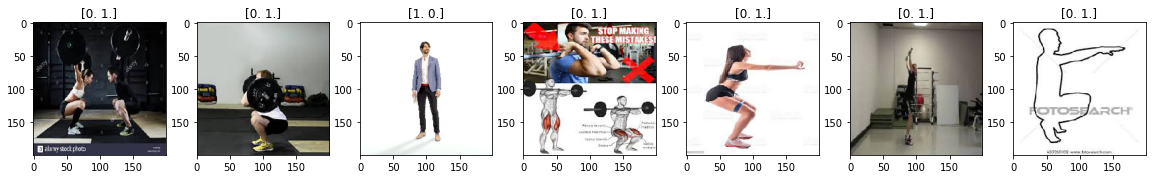

In [6]:
# specifying the overall grid size
plt.figure(figsize=(20, 20))

for i in range(7):
    plt.subplot(7, 7, i+1)
    plt.title(str(y_train[i]))
    plt.imshow(x_train[i].astype('uint8'))
plt.show()

In [7]:
# Set the parameters for a performance export
conv_size = 96
momentum = 0.4

In [8]:
model = keras.Sequential()

model.add(layers.Conv2D(conv_size, (5, 5),
                        activation='relu',
                        input_shape=input_shape))
model.add(layers.Conv2D(128, (4, 4), activation='relu'))

model.add(layers.BatchNormalization(momentum=momentum))
model.add(layers.MaxPooling2D(pool_size=(6, 6)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(output_shape, activation='softmax'))

model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 196, 196, 96)      7296      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 193, 193, 128)     196736    
_________________________________________________________________
batch_normalization (BatchNo (None, 193, 193, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [9]:
batch_size = 32
epochs = 30
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/30
31/31 [==============================] - 12s 181ms/step - loss: 29.6264 - categorical_accuracy: 0.5062 - val_loss: 41.8815 - val_categorical_accuracy: 0.5425
Epoch 2/30
31/31 [==============================] - 5s 161ms/step - loss: 6.7113 - categorical_accuracy: 0.6020 - val_loss: 4.2762 - val_categorical_accuracy: 0.5830
Epoch 3/30
31/31 [==============================] - 5s 154ms/step - loss: 1.2612 - categorical_accuracy: 0.6052 - val_loss: 1.8775 - val_categorical_accuracy: 0.6235
Epoch 4/30
31/31 [==============================] - 5s 154ms/step - loss: 0.7382 - categorical_accuracy: 0.7004 - val_loss: 1.3467 - val_categorical_accuracy: 0.6802
Epoch 5/30
31/31 [==============================] - 5s 155ms/step - loss: 0.6239 - categorical_accuracy: 0.7181 - val_loss: 1.4084 - val_categorical_accuracy: 0.6964
Epoch 6/30
31/31 [==============================] - 5s 155ms/step - loss: 0.6008 - categorical_accuracy: 0.7213 - val_loss: 0.8587 - val_categorical_accuracy: 0.8057
E

Test loss: 0.738440215587616
Test accuracy: 0.8542510271072388


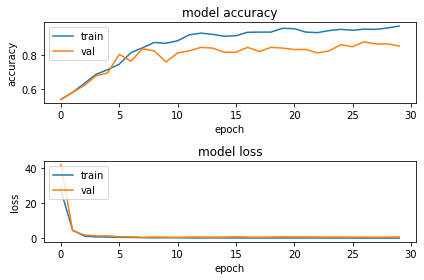

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

plt.figure(1)

# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()

# save format convolution layer size, batch
# normalization momentum, batch size, epochs
save_to = './performance-logs/%s-%s-%s-%s.jpeg' % (str(conv_size), str(momentum), str(batch_size), str(epochs))
plt.savefig(save_to)

plt.show()



### Verify the predictions being made
---

Number of incorrectly identified non-squats:  16


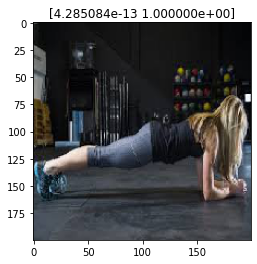

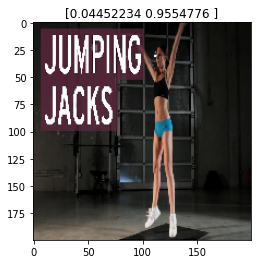

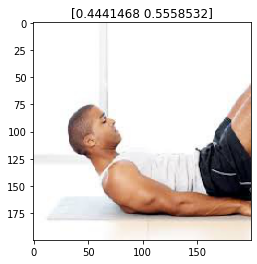

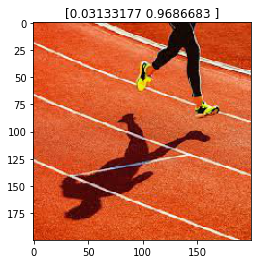

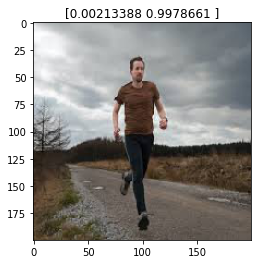

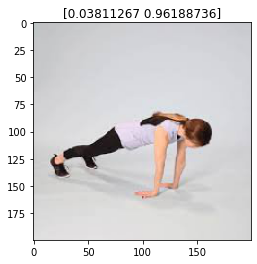

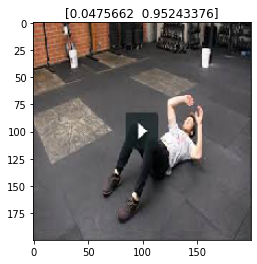

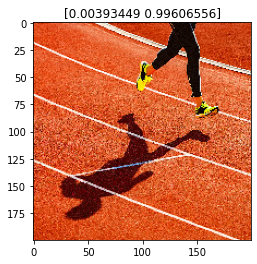

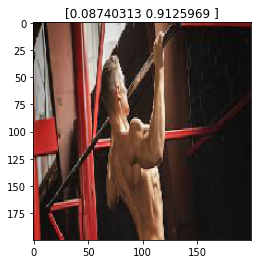

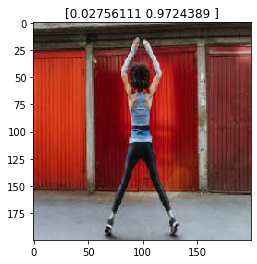

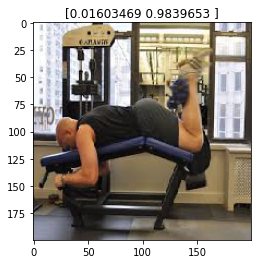

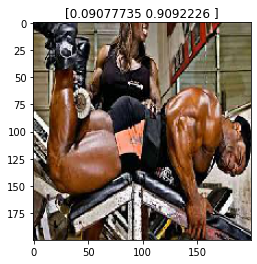

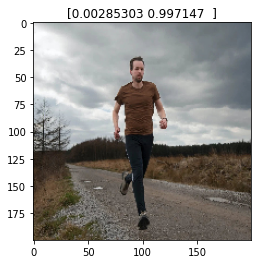

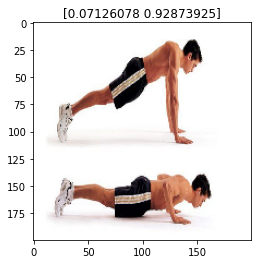

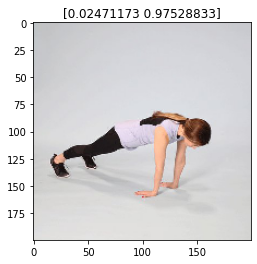

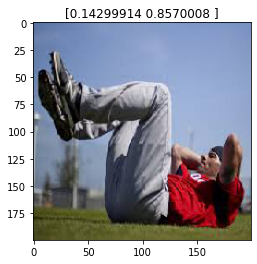


Number of incorrectly identified squats:  20


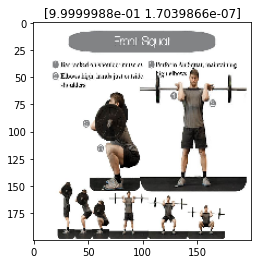

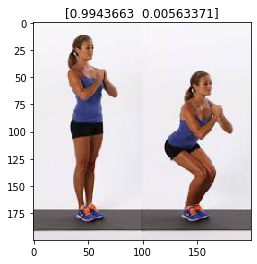

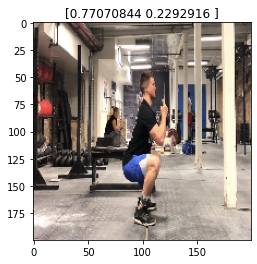

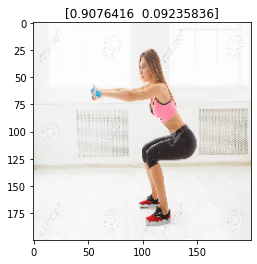

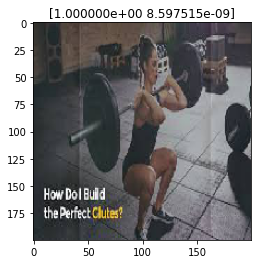

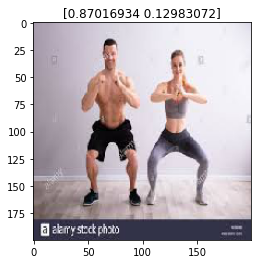

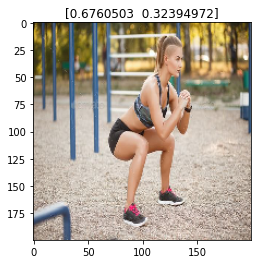

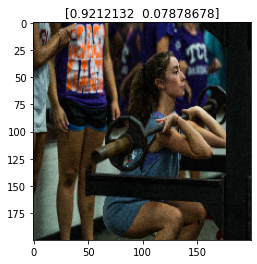

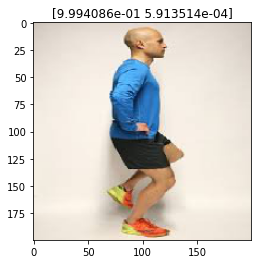

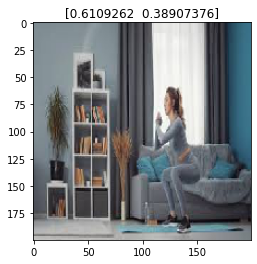

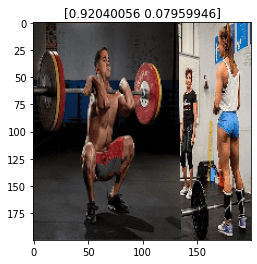

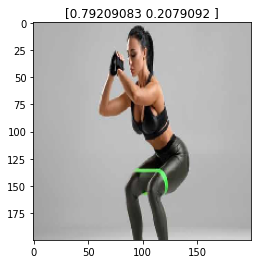

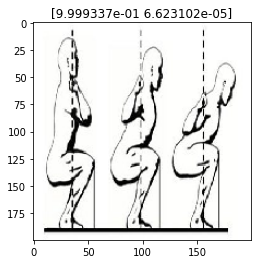

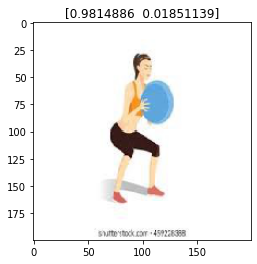

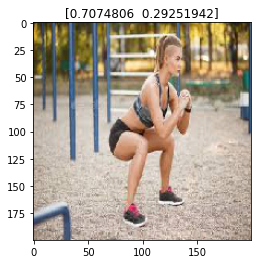

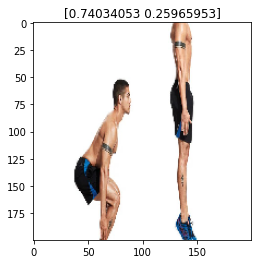

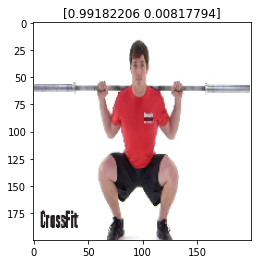

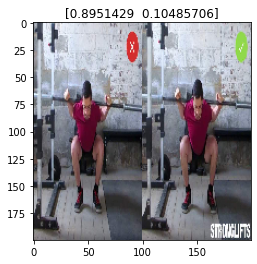

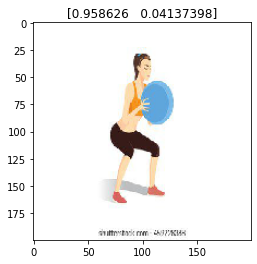

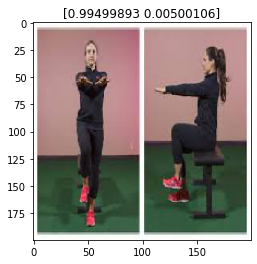

In [23]:
def decoder(one_pred):
    if one_pred[0] > one_pred[1]:
        return np.float32([1, 0])
    else:
        return [0, 1]


squat_preds = model.predict(x_test)
decoded = np.apply_along_axis(decoder, 1, squat_preds)

incorrect_squats = []
incorrect_non_squats = []

for i in range(len(y_test)):
    if (np.array_equal(decoded[i], y_test[i])) is False:
        if y_test[i][0] == 1:
            incorrect_non_squats.append(i)
        else:
            incorrect_squats.append(i)

print('\nNumber of incorrectly identified squats: ', len(incorrect_squats))
for i in incorrect_squats:
    plt.imshow(image.array_to_img(x_test[i, :, :, :]))
    plt.title(str(squat_preds[i]))
    plt.show()

print('Number of incorrectly identified non-squats: ', len(incorrect_non_squats))
for i in incorrect_non_squats:
    plt.imshow(image.array_to_img(x_test[i, :, :, :]))
    plt.title(str(squat_preds[i]))
    plt.show()